## Loading modules and the dataset

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import xgboost
import bs4
import re

In [2]:
# Dataset
original_df = pd.read_csv("data/train.csv", delimiter=",")

## Linking the questions labels to the questions title
Using the HTML file, we can access to labels questions which gathered additional information to know how to use these data

In [44]:
html_file = "data/USCODE22_LLCP_102523.HTML"
out_csv = "data/labels_questions.csv"

# Reading HTML 
with open(html_file, encoding="latin-1") as f:
    html = f.read()

soup = bs4.BeautifulSoup(html, "html.parser")

# Extracting blocks of questions
questions = []

for td in soup.find_all("td", class_="l m linecontent"):
    text = td.get_text(separator=" ", strip=True)
    text = text.replace("\xa0", " ")  
    text = re.sub(r"\s+", " ", text)

    # Extracting the different information
    label_match = re.search(r"Label:\s(.*?)\s+(?:Section Name:|Core Section Name:)", text, re.IGNORECASE)
    section_name_match = re.search(r"(?:Section Name:|Core Section Name:)\s(.*?)\s+(?:Section Number:|Core Section Number:|Module Number:)", text, re.IGNORECASE)
    section_number_match = re.search(r"(?:Section Number:|Core Section Number:|Module Number:)\s*([0-9A-Za-z]+)", text, re.IGNORECASE)
    sas_match = re.search(r"SAS Variable Name:\s*([A-Za-z0-9_]+)", text, re.IGNORECASE)

    questions.append({
        "Label": label_match.group(1).strip() if label_match else "",
        "Section Name": section_name_match.group(1).strip() if section_name_match else "",
        "Section Number": section_number_match.group(1).strip() if section_number_match else "", 
        "SAS_Variable_Name": sas_match.group(1).strip() if sas_match else ""
        })

# Conversion to df
labels_questions_df = pd.DataFrame(questions)

# Saving labels df
labels_questions_df.to_csv(out_csv, index=False, encoding="utf-8")

In [ ]:
# Which are the different sections
labels_questions_df["Section Name"].unique()

array(['Record Identification', 'Land Line Introduction',
       'Cell Phone Introduction', 'Respondent Sex', 'Health Status',
       'Healthy Days', 'Health Care Access', 'Exercise',
       'Inadequate Sleep', 'Oral Health', 'Chronic Health Conditions',
       'Demographics', 'Disability',
       'Breast and Cervical Cancer Screening',
       'Colorectal Cancer Screening', 'Tobacco Use',
       'Lung Cancer Screening', 'Alcohol Consumption', 'Immunization',
       'HIV/AIDS', 'Long-term COVID Effects', 'Pre-Diabetes', 'Diabetes',
       'ME/CFS', 'Place of Flu Vaccination', 'HPV Vaccination',
       'Shingles Vaccination', 'COVID Vaccination', 'Respiratory Health',
       'Cancer Survivorship: Type of Cancer',
       'Cancer Survivorship: Course of Treatment',
       'Cancer Survivorship: Pain Management',
       'Prostate Cancer Screening', 'Cognitive Decline', 'Caregiver',
       'Adverse Childhood Experiences',
       'Social Determinants and Health Equity', 'Marijuana Use',
      

In [ ]:
# Which are the different sections
len(labels_questions_df["Section Name"].unique())

56

In [64]:
# Removing useless sections
section_to_remove = ['Record Identification', 
                    'Questionnaire Version',
                    'Questionnaire Language']

sas_variable_associated = labels_questions_df[labels_questions_df["Section Name"].isin(section_to_remove)]["SAS_Variable_Name"].to_list()

labels1_questions_df = labels_questions_df[~labels_questions_df['Section Name'].isin(section_to_remove)].reset_index(drop=True)
original1_df = original_df.copy().drop(sas_variable_associated, axis=1)

print(f"Removed {original_df.shape[1] - original1_df.shape[1]} features : from {original_df.shape[1]} to {original1_df.shape[1]}")

Removed 11 features : from 325 to 314


Remove full NaN columns

In [66]:
# Removing full Nan columns
cols_all_nan = original1_df.columns[original1_df.isna().all()].tolist()

# Drop the columns and the lines in the label file
original2_df = original1_df.drop(cols_all_nan, axis=1)
labels2_questions_df = labels1_questions_df[~labels1_questions_df['SAS_Variable_Name'].isin(cols_all_nan)].reset_index(drop=True)

print(f"Removed {original1_df.shape[1] - original2_df.shape[1]} features : from {original1_df.shape[1]} to {original2_df.shape[1]}")

Removed 3 features : from 314 to 311


Correlation matrix for 313 numeric columns (shape=(313, 313)):


,CTELENM1,PVTRESD1,COLGHOUS,STATERE1,CELPHON1,LADULT1,COLGSEX1,NUMADULT,LANDSEX1,NUMMEN,...,_LCSREC,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,ID
CTELENM1,1.000000,NaN,NaN,NaN,NaN,-0.000210,NaN,-0.003945,0.004311,NaN,...,NaN,-0.000509,-0.001731,-0.001634,-0.001534,-0.001588,-0.000366,0.012696,-0.000584,0.001296
PVTRESD1,NaN,1.000000,NaN,NaN,NaN,-0.000759,0.372104,-0.010439,-0.003106,-0.011095,...,-0.010634,0.001061,-0.001746,-0.001157,-0.001274,-0.001475,-0.005694,-0.004725,0.001997,-0.003322
COLGHOUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STATERE1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CELPHON1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_RFDRHV8,-0.001588,-0.001475,NaN,NaN,NaN,-0.004983,0.206725,0.011733,0.004532,-0.003085,...,-0.001293,0.930063,0.963157,0.939162,0.996869,1.000000,0.724171,0.660030,0.052056,-0.000108
_FLSHOT7,-0.000366,-0.005694,NaN,NaN,NaN,-0.004565,-0.487950,0.025119,0.012160,0.007335,...,0.033632,0.729322,0.725923,0.719143,0.726433,0.724171,1.000000,0.859565,0.045147,-0.001076
_PNEUMO3,0.012696,-0.004725,NaN,NaN,NaN,-0.004430,0.600000,0.016723,-0.017777,0.006025,...,0.024072,0.662913,0.662212,0.655999,0.661912,0.660030,0.859565,1.000000,0.059142,-0.000760
_AIDTST4,-0.000584,0.001997,NaN,NaN,NaN,0.000972,0.237872,-0.030485,0.009093,-0.011248,...,-0.010931,0.073395,0.063574,0.043583,0.055644,0.052056,0.045147,0.059142,1.000000,0.003383


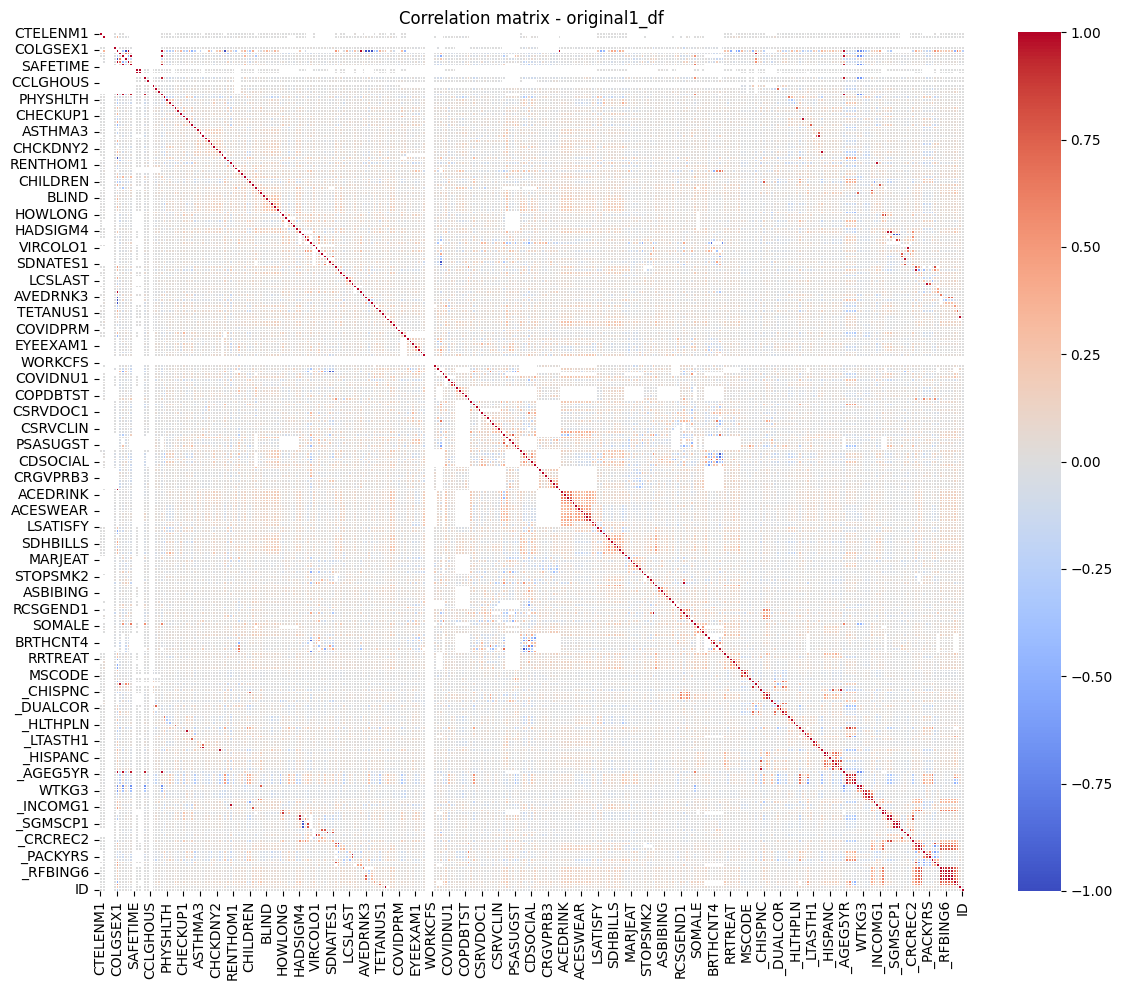

In [62]:
# Afficher la matrice de corrélation des colonnes numériques de original1_df
num_cols = original1_df.select_dtypes(include=[np.number]).columns.tolist()

# Calcul de la matrice de corrélation
corr_matrix = original1_df[num_cols].corr()

# Affichage tableau
print(f"Correlation matrix for {len(num_cols)} numeric columns (shape={corr_matrix.shape}):")
display(corr_matrix)

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1, center=0, square=False, linewidths=0.4)
plt.title("Correlation matrix - original1_df")
plt.tight_layout()
plt.show()

Looking at the correlations of each groups of questions with the target

In [61]:
import numpy as np

# Calcul de la matrice de corrélation absolue, moyenne par "Section Name" et classement

# colonnes numériques du dataset nettoyé
num_cols = original1_df.select_dtypes(include=[np.number]).columns.tolist()

# matrice de corrélation en valeur absolue
corr_abs = original1_df[num_cols].corr().abs()

# mapping SAS variable -> Section Name depuis labels1_questions_df
mapping = labels1_questions_df.set_index('SAS_Variable_Name')['Section Name'].to_dict()

# liste des sections présentes dans le mapping
sections = labels1_questions_df['Section Name'].unique().tolist()

section_stats = []
for sec in sections:
    # variables de la section qui existent dans original1_df (numériques)
    vars_in_sec = [v for v in labels1_questions_df[labels1_questions_df['Section Name'] == sec]['SAS_Variable_Name'].tolist() if v in num_cols]
    if not vars_in_sec:
        continue

    # pour chaque variable, moyenne des corrélations absolues avec les autres variables (excluant elle-même)
    per_var_mean = []
    for v in vars_in_sec:
        # drop self-correlation
        others = corr_abs.loc[v].drop(labels=[v], errors='ignore')
        if others.shape[0] == 0:
            per_var_mean.append(np.nan)
        else:
            per_var_mean.append(others.mean())

    # moyenne par section (ignorer NaN)
    section_mean = np.nanmean(per_var_mean)
    section_stats.append({"Section Name": sec, "n_variables": len(vars_in_sec), "mean_abs_corr_with_others": section_mean})

section_ranking = pd.DataFrame(section_stats).sort_values("mean_abs_corr_with_others", ascending=False).reset_index(drop=True)

# Si un target est détectable automatiquement, calcule aussi la moyenne des corrélations vers le target
possible_targets = [c for c in original1_df.columns if c.lower() in ("target", "y", "label", "outcome", "response")]
target_ranking = None
if possible_targets:
    target_var = possible_targets[0]
    # s'assurer que target est numérique et présent dans corr_abs
    if target_var in corr_abs.columns:
        sec_stats_target = []
        for sec in sections:
            vars_in_sec = [v for v in labels1_questions_df[labels1_questions_df['Section Name'] == sec]['SAS_Variable_Name'].tolist() if v in num_cols]
            if not vars_in_sec:
                continue
            vals = corr_abs.loc[vars_in_sec, target_var].dropna().values
            if vals.size == 0:
                mean_t = np.nan
            else:
                mean_t = vals.mean()
            sec_stats_target.append({"Section Name": sec, "n_variables": len(vars_in_sec), f"mean_abs_corr_with_{target_var}": mean_t})
        target_ranking = pd.DataFrame(sec_stats_target).sort_values(f"mean_abs_corr_with_{target_var}", ascending=False).reset_index(drop=True)

# Affichage des résultats
print("Classement par moyenne des corrélations absolues (avec toutes les autres variables) :")
display(section_ranking)

if target_ranking is not None:
    print(f"\nClassement par moyenne des corrélations absolues avec la variable target détectée: '{target_var}' :")
    display(target_ranking)
else:
    print("\nAucune variable target automatique détectée parmi les noms courants (target, y, label, outcome, response).")
    print("Si vous souhaitez classer par rapport à une variable cible spécifique, définissez target_var = 'NOM_COLONNE' et relancez ce bloc.")

Classement par moyenne des corrélations absolues (avec toutes les autres variables) :


/var/folders/0x/tnwyycrs76jb4wzv1753ymx40000gn/T/ipykernel_97756/2318977727.py:35: RuntimeWarning: Mean of empty slice
  section_mean = np.nanmean(per_var_mean)


,Section Name,n_variables,mean_abs_corr_with_others
0,Cognitive Decline,6,0.079929
1,Sex at Birth,1,0.077190
2,Prostate Cancer Screening,5,0.075650
3,Cancer Survivorship: Pain Management,2,0.075233
4,Adverse Childhood Experiences,13,0.070077
5,HPV Vaccination,2,0.068475
6,Social Determinants and Health Equity,10,0.065129
7,Land Line Introduction,12,0.063424
8,Health Status,1,0.063150
9,Child Demographic Variables,3,0.062618



Aucune variable target automatique détectée parmi les noms courants (target, y, label, outcome, response).
Si vous souhaitez classer par rapport à une variable cible spécifique, définissez target_var = 'NOM_COLONNE' et relancez ce bloc.


## Cleaning the dataset
### Removing full NaN columns

In [11]:
# Checking for duplicates 
dup_counts = df['Label'].value_counts()
duplicates = dup_counts[dup_counts > 1]

print(f"Unique labels: {dup_counts.shape[0]}")
print(f"Duplicate labels: {duplicates.shape[0]}")

if duplicates.empty:
    print("No duplicates")
else:
    print("\nDuplicates & Occurrences:")
    print(duplicates)

    # Corresponding line
    dup_rows = df[df['Label'].isin(duplicates.index)].sort_values('Label').reset_index(drop=True)
    print("\nLines Duplicates:")
    print(dup_rows)

Unique labels: 317
Duplicate labels: 5

Duplicates & Occurrences:
Label
Are you male or female?              4
Do you live in college housing?      2
Number of Adults in Household        2
Are you 18 years of age or older?    2
Sexual orientation                   2
Name: count, dtype: int64

Lines Duplicates:
                                Label SAS_Variable_Name
0   Are you 18 years of age or older?           LADULT1
1   Are you 18 years of age or older?           CADULT1
2             Are you male or female?          COLGSEX1
3             Are you male or female?          LANDSEX1
4             Are you male or female?          CELLSEX1
5             Are you male or female?          BIRTHSEX
6     Do you live in college housing?          COLGHOUS
7     Do you live in college housing?          CCLGHOUS
8       Number of Adults in Household          NUMADULT
9       Number of Adults in Household           HHADULT
10                 Sexual orientation            SOMALE
11              

In [20]:
# Merging Similar Label questions : Are you 18 years of age or older? 
complementary_check = ((original_df["LADULT1"].notna() & original_df["CADULT1"].isna()) |
                       (original_df["LADULT1"].isna() & original_df["CADULT1"].notna()))
print(complementary_check.describe())

merged_df = original_df["LADULT1"].fillna(0) + original_df["CADULT1"].fillna(0)


count     225000
unique         1
top         True
freq      225000
dtype: object


In [67]:
# Merging Similar Label questions : Are you 18 years of age or older? 
complementary_check = ((original_df["COLGHOUS"].notna() & original_df["CCLGHOUS"].isna()) |
                       (original_df["COLGHOUS"].isna() & original_df["CCLGHOUS"].notna()))
print(complementary_check.describe())

merged_df = original_df["COLGHOUS"].fillna(0) + original_df["CCLGHOUS"].fillna(0)
print(merged_df)


count     225000
unique         2
top        False
freq      224249
dtype: object
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
224995    0.0
224996    0.0
224997    0.0
224998    0.0
224999    0.0
Length: 225000, dtype: float64


In [23]:
# Merging Similar Label questions : Are you 18 years of age or older? 
complementary_check = ((original_df["NUMADULT"].notna() & original_df["HHADULT"].isna()) |
                       (original_df["NUMADULT"].isna() & original_df["HHADULT"].notna()))
print(complementary_check.describe())

merged_df = original_df["NUMADULT"].fillna(0) + original_df["HHADULT"].fillna(0)
print(merged_df)


count     225000
unique         2
top         True
freq      224983
dtype: object
0         1.0
1         2.0
2         2.0
3         2.0
4         4.0
         ... 
224995    3.0
224996    1.0
224997    2.0
224998    1.0
224999    2.0
Length: 225000, dtype: float64


## 